# Part IV: Modelling

## Basic settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import pickle
import sys
import warnings
from datetime import datetime, timedelta

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

# Set random seed for reproducibility
np.random.seed(2025)

/home/research/miniconda3/envs/sales_forecasting_ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
src_path = os.path.abspath(os.path.join("../..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

In [4]:
from utils.plots import plot_forecast_single
from utils.utils import flatten_prophet_predictions, weighted_absolute_percentage_error

In [5]:
import os
import pandas as pd
import numpy as np

DATA_DIR = "../../data"

# 1. LOAD DATA ĐÃ PREPROCESS VÀ FEATURE ENGINEERING
df_sales = pd.read_csv(
    os.path.join(DATA_DIR, "data_processed/sales_data_preprocessed.csv"),
    parse_dates=["date"]
)
df_weather = pd.read_csv(
    os.path.join(DATA_DIR, "data_processed/weather_preprocessed.csv"),
    parse_dates=["date"]
)
df_weather_key_store_merged = pd.read_csv(
    os.path.join(DATA_DIR, "data_processed/weather_key_store_merged.csv"),
    parse_dates=["date"]
)

# Đây là file đã có is_kaggle_test và toàn bộ features
df_features = pd.read_feather(os.path.join(DATA_DIR,'data_processed/feature_engineered_data_89_features.feather'))

print("Full feature data:", df_features.shape)
print("Kaggle test rows:", df_features['is_kaggle_test'].sum())
print("Train rows:", (df_features['is_kaggle_test'] == 0).sum())




Full feature data: (686187, 89)
Kaggle test rows: 526917
Train rows: 159270


## Load data

In [6]:
df_features['is_valid'] = 0
mask_train = df_features['is_kaggle_test'] == 0
cutoff_date = pd.Timestamp("2014-08-01")
df_features.loc[mask_train & (df_features['date'] >= cutoff_date), 'is_valid'] = 1

# 2. Tách train/valid và kaggle test
df_train = df_features[(df_features['is_kaggle_test'] == 0) & (df_features['is_valid'] == 0)].copy()
df_valid = df_features[(df_features['is_kaggle_test'] == 0) & (df_features['is_valid'] == 1)].copy()
df_kaggle_test = df_features[df_features['is_kaggle_test'] == 1].copy()

print("Final splits:")
print("  Train:", df_train.shape)
print("  Valid:", df_valid.shape)
print("  Kaggle test:", df_kaggle_test.shape)

Final splits:
  Train: (153496, 90)
  Valid: (5774, 90)
  Kaggle test: (526917, 90)


In [7]:
df_kaggle_test

,date,store_nbr,item_nbr,units,logunits,is_kaggle_test,station_nbr,tmax,depart,cool,...,logunits_ewma_14d_a05,logunits_ewma_28d_a05,logunits_ewma_7d_a075,logunits_ewma_14d_a075,logunits_ewma_28d_a075,store_sum_7d,store_mean_7d,item_sum_7d,item_mean_7d,is_valid
159270,2013-04-01,2,1,NaN,NaN,True,14,71.0,1.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,8.670772,1.238682,7.203406,1.029058,0
159271,2013-04-01,3,1,NaN,NaN,True,7,68.0,6.200000,0.0,...,NaN,NaN,NaN,NaN,NaN,8.825560,1.260794,6.510258,1.085043,0
159272,2013-04-01,6,1,NaN,NaN,True,14,71.0,1.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,12.102488,1.728927,5.817111,1.163422,0
159273,2013-04-01,7,1,NaN,NaN,True,6,86.0,6.000000,5.0,...,NaN,NaN,NaN,NaN,NaN,8.648221,1.235460,5.123964,1.280991,0
159274,2013-04-01,8,1,NaN,NaN,True,4,87.0,8.000000,9.0,...,NaN,NaN,NaN,NaN,NaN,9.572480,1.367497,3.178054,1.059351,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686182,2014-10-26,1,111,NaN,NaN,True,1,58.0,5.666667,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693147,0.693147,0
686183,2014-10-26,14,111,NaN,NaN,True,16,58.0,7.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693147,0.693147,0
686184,2014-10-26,16,111,NaN,NaN,True,2,53.0,2.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693147,0.693147,0
686185,2014-10-26,19,111,NaN,NaN,True,15,57.0,4.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693147,0.693147,0


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153496 entries, 0 to 159249
Data columns (total 90 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   date                    153496 non-null  datetime64[ns]
 1   store_nbr               153496 non-null  int64         
 2   item_nbr                153496 non-null  int64         
 3   units                   153496 non-null  float64       
 4   logunits                153496 non-null  float64       
 5   is_kaggle_test          153496 non-null  bool          
 6   station_nbr             153496 non-null  int64         
 7   tmax                    153496 non-null  float64       
 8   depart                  153496 non-null  float64       
 9   cool                    153496 non-null  float64       
 10  sunrise                 153496 non-null  float64       
 11  sunset                  153496 non-null  float64       
 12  snowfall                153496 non-

## Base line model

In [9]:
prophet_train_data = (
    df_train.groupby(['store_nbr', 'item_nbr', 'date'], as_index=False)
    .agg({
        'logunits': 'sum',
        'is_weekend': 'first',
        'is_holiday': 'first',
        'cool': 'mean',
        'preciptotal': 'mean'
    })
    .rename(columns={
        'date': 'ds',
        'logunits': 'y',
        'cool': 'temp',
        'preciptotal': 'rain'
    })
)

prophet_valid_data = (
    df_valid.groupby(['store_nbr', 'item_nbr', 'date'], as_index=False)
    .agg({
        'logunits': 'sum',
        'is_weekend': 'first',
        'is_holiday': 'first',
        'cool': 'mean',
        'preciptotal': 'mean'
    })
    .rename(columns={
        'date': 'ds',
        'logunits': 'y',
        'cool': 'temp',
        'preciptotal': 'rain'
    })
)

print("Prophet train shape:", prophet_train_data.shape)
print("Prophet valid shape:", prophet_valid_data.shape)

Prophet train shape: (153496, 8)
Prophet valid shape: (5774, 8)


In [10]:
prophet_train_data

,store_nbr,item_nbr,ds,y,is_weekend,is_holiday,temp,rain
0,1,9,2012-01-29,5.225747,1,0,0.0,0.000000
1,1,9,2012-01-30,4.304065,0,0,0.0,0.118415
2,1,9,2012-01-31,3.688879,0,0,0.0,0.118415
3,1,9,2012-02-01,4.110874,0,0,0.0,0.010000
4,1,9,2012-02-02,4.343805,0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...
153491,45,50,2014-06-18,0.000000,0,0,12.0,0.125842
153492,45,50,2014-06-19,0.000000,0,1,5.0,0.000000
153493,45,50,2014-06-20,0.000000,0,0,0.0,0.000000
153494,45,50,2014-06-21,0.000000,1,0,0.0,0.000000


In [11]:
def build_prophet_model(prophet_train_data, prophet_valid_data):
    print("Building Prophet models...")
    
    # Lấy pairs từ TRAIN data
    pairs = prophet_train_data[['store_nbr', 'item_nbr']].drop_duplicates()
    
    prophet_predictions = {}
    prophet_models = {}
    prophet_metrics = pd.DataFrame(columns=['store_nbr', 'item_nbr', 'mae', 'rmse', 'wape'])
    all_actual, all_predicted = [], []
    
    skipped = 0
    for _, row in pairs.iterrows():
        # Ép kiểu int rõ ràng để đồng bộ với lúc dự đoán
        s, i = int(row['store_nbr']), int(row['item_nbr'])
        
        # TRAIN từ prophet_train_data
        combo_train = prophet_train_data[
            (prophet_train_data['store_nbr'] == s) & 
            (prophet_train_data['item_nbr'] == i)
        ].copy()
        
        # TEST từ prophet_valid_data  
        combo_test = prophet_valid_data[
            (prophet_valid_data['store_nbr'] == s) & 
            (prophet_valid_data['item_nbr'] == i)
        ].copy()
        
        # CHỈ SKIP NẾU KHÔNG CÓ DỮ LIỆU TRAIN
        if combo_train.empty:
            skipped += 1
            continue
            
        # Train Prophet
        m = Prophet(
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True,
            seasonality_mode='multiplicative'
        )
        
        for reg in ['is_weekend', 'is_holiday', 'temp', 'rain']:
            m.add_regressor(reg)
            
        m.fit(combo_train[['ds', 'y', 'is_weekend', 'is_holiday', 'temp', 'rain']])
        
        # Lưu Model (Lưu key là int)
        key = (s, i)
        prophet_models[key] = m
        
        # Chỉ tính metrics nếu có dữ liệu validation (combo_test không rỗng)
        if not combo_test.empty:
            future = combo_test[['ds', 'is_weekend', 'is_holiday', 'temp', 'rain']]
            fcst = m.predict(future)
            fcst = fcst[['ds', 'yhat']].merge(combo_test[['ds', 'y']], on='ds')
            
            prophet_predictions[key] = fcst
            
            # Metrics
            mae = mean_absolute_error(fcst['y'], fcst['yhat'])
            rmse = np.sqrt(mean_squared_error(fcst['y'], fcst['yhat']))
            wape = weighted_absolute_percentage_error(fcst['y'], fcst['yhat'])
            
            prophet_metrics.loc[len(prophet_metrics)] = [s, i, mae, rmse, wape]
            all_actual.extend(fcst['y'])
            all_predicted.extend(fcst['yhat'])
    
    print(f"Skipped: {skipped}/{len(pairs)} pairs (due to missing training data)")
    print(f"Models built: {len(prophet_models)}")
    
    # Tính metrics tổng (chỉ trên những model có validation)
    if len(prophet_metrics) > 0:
        avg_mae = prophet_metrics['mae'].mean()
        avg_rmse = prophet_metrics['rmse'].mean()
        avg_wape = weighted_absolute_percentage_error(np.array(all_actual), np.array(all_predicted))
        
        print(f"\nOverall Validation Metrics (on {len(prophet_metrics)} validated models):")
        print(f"MAE: {avg_mae:.4f} | RMSE: {avg_rmse:.4f} | WAPE: {avg_wape:.4f}")
        return prophet_models, prophet_predictions, (avg_mae, avg_rmse, avg_wape)
    else:
        print("\nWarning: No validation data available for any model.")
        return prophet_models, prophet_predictions, (0, 0, 0)

In [12]:
prophet_models, prophet_predictions, metrics = build_prophet_model(
    prophet_train_data, 
    prophet_valid_data
)

Building Prophet models...


18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing


18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:21 - cmdstanpy - INFO - Chain [1] done processing
18:42:21 - cmdstanpy - INFO - Chain [1] start processing
18:42:22 - cmdstanpy - INFO - Chain [1] done processing
18:42:22 - cmdstanpy - INFO - Chain [1] start processing
18:42:22 - cmdstanpy - INFO - Chain [1] done processing
18:42:22 - cmdstanpy - INFO - Chain [1] start processing
18:42:22 - cmdstanpy - INFO - Chain [1] done processing
18:42:22 - cmdstanpy - INFO - Chain [1] start processing
18:42:22 - cmdstanpy - INFO - Chain [1] done processing
18:42:22 - cmdstanpy - INFO - Chain [1] start processing
18:42:22 - cmdstanpy - INFO - Chain [1] done processing
18:42:22 - cmdstanpy - INFO - Chain [1] start processing
18:42:22 - cmdstanpy - INFO - Chain [1] done processing
18:42:22 - cmdstanpy - INFO - Chain [1] 

Skipped: 0/255 pairs (due to missing training data)
Models built: 255

Overall Validation Metrics (on 205 validated models):
MAE: 0.3909 | RMSE: 0.4720 | WAPE: 24.5412


In [13]:
# Accuracy of Prophet Model
print(
    f"Prophet Model Results:\nMAE: {metrics[0]:.2f} | RMSE: {metrics[1]:.2f} | WAPE: {metrics[2]:.2f}%"
)

Prophet Model Results:
MAE: 0.39 | RMSE: 0.47 | WAPE: 24.54%


In [15]:
# 1. Lọc đúng dữ liệu cho tập Test (từ 01/04/2013 trở đi)
min_test_date = "2013-04-01"

df_kaggle_test_prophet = df_kaggle_test[
    (df_kaggle_test['is_kaggle_test'] == True) & 
    (df_kaggle_test['date'] >= min_test_date)
].copy()

df_kaggle_test_prophet = df_kaggle_test_prophet[[
    'store_nbr', 'item_nbr', 'date',
    'is_weekend', 'is_holiday', 'cool', 'preciptotal'
]].rename(columns={
    'date': 'ds',
    'cool': 'temp',
    'preciptotal': 'rain'
})

# 2. Dự đoán vòng lặp từng Store-Item
kaggle_preds = []
pairs_test = df_kaggle_test_prophet[['store_nbr','item_nbr']].drop_duplicates()

for _, row in pairs_test.iterrows():
    s, i = int(row['store_nbr']), int(row['item_nbr'])
    key = (s, i)

    df_si = df_kaggle_test_prophet[
        (df_kaggle_test_prophet['store_nbr'] == s) &
        (df_kaggle_test_prophet['item_nbr'] == i)
    ].copy()

    if key not in prophet_models:
        df_si['yhat'] = 0.0
    else:
        m = prophet_models[key]
        future = df_si[['ds','is_weekend','is_holiday','temp','rain']]
        fcst = m.predict(future)
        df_si = df_si.merge(fcst[['ds','yhat']], on='ds', how='left')

    kaggle_preds.append(df_si)

# 3. Gộp và xử lý kết quả dự đoán
df_kaggle_pred = pd.concat(kaggle_preds, ignore_index=True)
df_kaggle_pred['units'] = np.expm1(df_kaggle_pred['yhat']).clip(lower=0)
df_kaggle_pred['date_str'] = df_kaggle_pred['ds'].dt.strftime('%Y-%m-%d')

# 4. Sắp xếp theo yêu cầu Kaggle và tạo ID
df_kaggle_pred = df_kaggle_pred.sort_values(['date_str', 'store_nbr', 'item_nbr'])
df_kaggle_pred['id'] = (
    df_kaggle_pred['store_nbr'].astype(str) + '_' +
    df_kaggle_pred['item_nbr'].astype(str) + '_' +
    df_kaggle_pred['date_str']
)

submission = df_kaggle_pred[['id', 'units']].reset_index(drop=True)
submission.to_csv('submission_prophet.csv', index=False)

print(f"✓ Saved submission_prophet.csv ({len(submission)} rows)")
print("Sample IDs:", submission['id'].head().tolist())


✓ Saved submission_prophet.csv (526917 rows)
Sample IDs: ['2_1_2013-04-01', '2_2_2013-04-01', '2_3_2013-04-01', '2_4_2013-04-01', '2_5_2013-04-01']


In [16]:
# Kiểm tra nhanh: Đếm số lượng dòng dự đoán khác 0
non_zero_preds = submission[submission['units'] > 0]
print(f"Số lượng dòng có dự đoán bán hàng: {len(non_zero_preds)}")
print("Ví dụ 5 dòng có số liệu:")
print(non_zero_preds.head())

Số lượng dòng có dự đoán bán hàng: 21762
Ví dụ 5 dòng có số liệu:
                 id       units
4    2_5_2013-04-01   40.250135
10  2_11_2013-04-01    0.431184
43  2_44_2013-04-01  112.111058
84  2_85_2013-04-01    0.031153
92  2_93_2013-04-01    0.151883


## Build lightgbm model

### Split train and test data

In [ ]:
# Drop unnecessary columns for modeling
cols_to_drop = [
    "date",
    "province",
    "store_name",
    "item_name",
    "store_item",
    "is_test",
    "category",
]

# Split features and target, and separate train/test
X_train = df_features[~df_features["is_test"]].drop(cols_to_drop + ["sales"], axis=1)
y_train = df_features[~df_features["is_test"]]["sales"]

X_test = df_features[df_features["is_test"]].drop(cols_to_drop + ["sales"], axis=1)
y_test = df_features[df_features["is_test"]]["sales"]

KeyError: 'is_test'

In [ ]:
X_train

,store_id,item_id,temperature,humidity,year,month,day,day_of_week,is_weekend,quarter,...,sales_ewma_7d_a05,sales_ewma_14d_a05,sales_ewma_28d_a05,sales_ewma_7d_a075,sales_ewma_14d_a075,sales_ewma_28d_a075,store_mean_7d,store_sum_7d,item_mean_7d,item_sum_7d
7752,2,30,16.5,74.3,2016,1,29,4,0,1,...,19.492031,19.492031,19.492031,22.260379,22.260379,22.260379,24.089571,674.507994,25.125000,201.000000
7753,2,31,16.5,74.3,2016,1,29,4,0,1,...,22.468999,22.468999,22.468999,22.523939,22.523939,22.523939,24.089571,674.507994,34.333333,206.000000
7734,2,8,16.5,74.3,2016,1,29,4,0,1,...,11.903262,11.903262,11.903262,10.141156,10.141156,10.141156,24.089571,674.507994,19.111111,172.000000
7742,2,17,16.5,74.3,2016,1,29,4,0,1,...,51.371082,51.371082,51.371082,51.348363,51.348363,51.348363,24.089571,674.507994,49.428571,346.000000
7744,2,19,16.5,74.3,2016,1,29,4,0,1,...,33.927792,33.927792,33.927792,36.936238,36.936238,36.936238,24.089571,674.507994,39.833333,239.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175554,4,22,28.4,77.6,2017,9,30,5,1,3,...,27.279200,27.279200,27.279200,25.989762,25.989762,25.989762,30.982999,867.523983,37.000000,259.000000
175556,4,26,28.4,77.6,2017,9,30,5,1,3,...,16.494764,16.494764,16.494764,17.556100,17.556100,17.556100,30.982999,867.523983,18.125000,145.000000
175562,4,33,28.4,77.6,2017,9,30,5,1,3,...,18.248556,18.248556,18.248556,16.932354,16.932354,16.932354,30.982999,867.523983,16.714286,117.000000
175548,4,14,28.4,77.6,2017,9,30,5,1,3,...,87.188531,87.188531,87.188531,95.349882,95.349882,95.349882,30.982999,867.523983,53.646283,375.523983


### Build a lightgbm model

In [ ]:
def create_lightgbm_model(X_train, y_train, X_test, y_test):
    """
    Create a LightGBM model using engineered features
    """
    print("\nCreating base lightgbm model...")

    # Use a time series split for validation within the training set
    # This ensures we're always validating on future data
    tscv = TimeSeriesSplit(n_splits=5)

    # Basic LightGBM parameters
    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "num_leaves": 31,
        "learning_rate": 0.05,
        "feature_fraction": 0.9,
        "n_estimators": 100,
        "verbose": -1,
    }

    # Train the model with cross-validation on training data only
    cv_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model
        model = lgbm.LGBMRegressor(**params)
        model.fit(
            X_train_cv,
            y_train_cv,
            eval_set=[(X_val_cv, y_val_cv)],
            # early_stopping_rounds=50,
            # verbose=False
        )

        # Make predictions
        preds = model.predict(X_val_cv)

        # Calculate metrics
        mae = mean_absolute_error(y_val_cv, preds)
        rmse = np.sqrt(mean_squared_error(y_val_cv, preds))
        wape = weighted_absolute_percentage_error(y_val_cv, preds)

        cv_scores.append((mae, rmse, wape))

    # Print average scores from cross-validation
    mae_avg, rmse_avg, wape_avg = np.mean(cv_scores, axis=0)
    print(
        f"Baseline Model CV - MAE: {mae_avg:.2f}, RMSE: {rmse_avg:.2f}, WAPE: {wape_avg:.2f}%"
    )

    # Train a final model on all training data
    final_model = lgbm.LGBMRegressor(**params)
    final_model.fit(X_train, y_train)

    # Evaluate on the test set (last 3 months of 2017)
    test_preds = final_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_wape = weighted_absolute_percentage_error(y_test, test_preds)

    print(
        f"Baseline Model Test - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, WAPE: {test_wape:.2f}%"
    )

    return final_model, (test_mae, test_rmse, test_wape)

In [ ]:
# Create basic lgihtgbm model
lightgbm_model, lightgbm_metrics = create_lightgbm_model(
    X_train, y_train, X_test, y_test
)


Creating base lightgbm model...
Baseline Model CV - MAE: 7.00, RMSE: 11.10, WAPE: 25.62%
Baseline Model Test - MAE: 7.64, RMSE: 11.76, WAPE: 24.82%


### (Optional) Fine tunning using Optuna

In [ ]:
def optimize_lightgbm(X_train, y_train, X_test, y_test):
    """
    Optimize LightGBM model using Optuna
    """

    print("\nOptimizing LightGBM model with Optuna...")

    def objective(trial):
        """Optuna objective function for LightGBM optimization"""
        params = {
            "objective": "regression",
            "metric": "rmse",
            "boosting_type": "gbdt",
            "num_leaves": trial.suggest_int("num_leaves", 15, 50),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 30),
            "n_estimators": 1000,
            "verbose": -1,
        }

        # Train with early stopping
        model = lgbm.LGBMRegressor(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            callbacks=[lgbm.early_stopping(stopping_rounds=50)],
            # verbose=False,
        )

        # Predict and calculate RMSE
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        return rmse

    # Create and run study
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)  # In practice, use more trials

    # Get best parameters
    best_params = study.best_params
    best_params.update(
        {
            "objective": "regression",
            "metric": "rmse",
            "boosting_type": "gbdt",
            "verbose": -1,
        }
    )

    print("Best LightGBM parameters found:")
    for key, value in best_params.items():
        print(f"    {key}: {value}")

    # Train final model with best parameters
    final_model = lgbm.LGBMRegressor(**best_params)
    final_model.fit(X_train, y_train)

    # Make predictions
    test_preds = final_model.predict(X_test)

    # Calculate metrics
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_wape = weighted_absolute_percentage_error(y_test, test_preds)

    print(
        f"Optimized LightGBM Test Metrics - MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, WAPE: {test_wape:.2f}%"
    )

    return final_model, test_preds, (test_mae, test_rmse, test_wape)

In [ ]:
optimized_model, best_params, optimized_metrics = optimize_lightgbm(
    X_train, y_train, X_test, y_test
)

[I 2025-05-02 15:56:22,570] A new study created in memory with name: no-name-4508cb1f-c568-4ae8-8d1d-543406edb426



Optimizing LightGBM model with Optuna...
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:56:25,345] Trial 0 finished with value: 11.649999834393965 and parameters: {'num_leaves': 40, 'learning_rate': 0.08297978060044148, 'feature_fraction': 0.9019463161467259, 'bagging_fraction': 0.8764627124102412, 'bagging_freq': 3, 'min_child_samples': 24}. Best is trial 0 with value: 11.649999834393965.


Early stopping, best iteration is:
[140]	valid_0's rmse: 11.65
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:56:29,939] Trial 1 finished with value: 11.604653786850228 and parameters: {'num_leaves': 50, 'learning_rate': 0.059576663129270006, 'feature_fraction': 0.9819465596399095, 'bagging_fraction': 0.7369457351386607, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 1 with value: 11.604653786850228.


Early stopping, best iteration is:
[240]	valid_0's rmse: 11.6047
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:56:37,056] Trial 2 finished with value: 11.596828985916476 and parameters: {'num_leaves': 19, 'learning_rate': 0.03197864510455689, 'feature_fraction': 0.9103026019205502, 'bagging_fraction': 0.9646607285741408, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[878]	valid_0's rmse: 11.5968
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:56:41,508] Trial 3 finished with value: 11.642039619692293 and parameters: {'num_leaves': 33, 'learning_rate': 0.039451229734209746, 'feature_fraction': 0.9480222745541578, 'bagging_fraction': 0.7299802243107281, 'bagging_freq': 6, 'min_child_samples': 22}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[345]	valid_0's rmse: 11.642
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:56:50,894] Trial 4 finished with value: 11.614240642778121 and parameters: {'num_leaves': 30, 'learning_rate': 0.027357022165892725, 'feature_fraction': 0.7716864881161948, 'bagging_fraction': 0.9680992801019651, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[822]	valid_0's rmse: 11.6142
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:56:55,414] Trial 5 finished with value: 11.632428123987449 and parameters: {'num_leaves': 15, 'learning_rate': 0.04915194589457893, 'feature_fraction': 0.9556165495634417, 'bagging_fraction': 0.9567622714054037, 'bagging_freq': 8, 'min_child_samples': 27}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[626]	valid_0's rmse: 11.6324
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:57:01,372] Trial 6 finished with value: 11.635322991075407 and parameters: {'num_leaves': 17, 'learning_rate': 0.04138434151149077, 'feature_fraction': 0.8103273603246913, 'bagging_fraction': 0.9411952011105488, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[768]	valid_0's rmse: 11.6353
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:57:05,089] Trial 7 finished with value: 11.683546193879376 and parameters: {'num_leaves': 44, 'learning_rate': 0.08025436185671957, 'feature_fraction': 0.7141717293983597, 'bagging_fraction': 0.7889999796549785, 'bagging_freq': 9, 'min_child_samples': 17}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[210]	valid_0's rmse: 11.6835
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:57:09,513] Trial 8 finished with value: 11.644138827149211 and parameters: {'num_leaves': 17, 'learning_rate': 0.06113562593384454, 'feature_fraction': 0.7532497370430334, 'bagging_fraction': 0.8213093572929867, 'bagging_freq': 6, 'min_child_samples': 20}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[574]	valid_0's rmse: 11.6441
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:57:12,799] Trial 9 finished with value: 11.668722344822951 and parameters: {'num_leaves': 31, 'learning_rate': 0.08713684451193092, 'feature_fraction': 0.816807935721348, 'bagging_fraction': 0.7415203241183309, 'bagging_freq': 10, 'min_child_samples': 6}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[255]	valid_0's rmse: 11.6687
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:57:21,111] Trial 10 finished with value: 11.601668749016772 and parameters: {'num_leaves': 24, 'learning_rate': 0.019162957293801824, 'feature_fraction': 0.8871121050578056, 'bagging_fraction': 0.888487105240534, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 2 with value: 11.596828985916476.


Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 11.6017
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:57:29,821] Trial 11 finished with value: 11.651894892502847 and parameters: {'num_leaves': 24, 'learning_rate': 0.01040319715120503, 'feature_fraction': 0.8865605849457928, 'bagging_fraction': 0.8970265965840643, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 2 with value: 11.596828985916476.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 11.6519
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:57:38,376] Trial 12 finished with value: 11.625149168309406 and parameters: {'num_leaves': 24, 'learning_rate': 0.014977807118576363, 'feature_fraction': 0.8833779813901699, 'bagging_fraction': 0.909097090864725, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 2 with value: 11.596828985916476.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 11.6251
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:57:47,784] Trial 13 finished with value: 11.616592089001601 and parameters: {'num_leaves': 23, 'learning_rate': 0.027301299898921653, 'feature_fraction': 0.9195697067663446, 'bagging_fraction': 0.855317172352172, 'bagging_freq': 3, 'min_child_samples': 14}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[949]	valid_0's rmse: 11.6166
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:57:56,239] Trial 14 finished with value: 11.615447069452726 and parameters: {'num_leaves': 22, 'learning_rate': 0.02637137974442341, 'feature_fraction': 0.8555265758180555, 'bagging_fraction': 0.9973856174483483, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[856]	valid_0's rmse: 11.6154
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:58:06,888] Trial 15 finished with value: 11.606916160712956 and parameters: {'num_leaves': 28, 'learning_rate': 0.020231531249513955, 'feature_fraction': 0.8463966022261085, 'bagging_fraction': 0.9207119819258338, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 2 with value: 11.596828985916476.


Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 11.6069
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:58:12,359] Trial 16 finished with value: 11.631610982036559 and parameters: {'num_leaves': 36, 'learning_rate': 0.03793874470415355, 'feature_fraction': 0.9287871247588034, 'bagging_fraction': 0.9999898299381249, 'bagging_freq': 2, 'min_child_samples': 22}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[385]	valid_0's rmse: 11.6316
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:58:16,110] Trial 17 finished with value: 11.654206290701124 and parameters: {'num_leaves': 20, 'learning_rate': 0.04969146488347778, 'feature_fraction': 0.9868294084273127, 'bagging_fraction': 0.8215097036375056, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[379]	valid_0's rmse: 11.6542
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:58:22,565] Trial 18 finished with value: 11.60739357416657 and parameters: {'num_leaves': 27, 'learning_rate': 0.03349349542774975, 'feature_fraction': 0.8563171370720217, 'bagging_fraction': 0.8841303637168685, 'bagging_freq': 7, 'min_child_samples': 28}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[570]	valid_0's rmse: 11.6074
Training until validation scores don't improve for 50 rounds


[I 2025-05-02 15:58:26,191] Trial 19 finished with value: 11.668503267369525 and parameters: {'num_leaves': 19, 'learning_rate': 0.07189497020621421, 'feature_fraction': 0.8219713864681434, 'bagging_fraction': 0.9455749619094662, 'bagging_freq': 8, 'min_child_samples': 18}. Best is trial 2 with value: 11.596828985916476.


Early stopping, best iteration is:
[382]	valid_0's rmse: 11.6685
Best LightGBM parameters found:
    num_leaves: 19
    learning_rate: 0.03197864510455689
    feature_fraction: 0.9103026019205502
    bagging_fraction: 0.9646607285741408
    bagging_freq: 6
    min_child_samples: 22
    objective: regression
    metric: rmse
    boosting_type: gbdt
    verbose: -1
Optimized LightGBM Test Metrics - MAE: 7.84, RMSE: 11.95, WAPE: 25.48%


## Evaluating model

In [ ]:
def evaluate_model(model, X_test, y_test, data):
    """
    Evaluate the model performance on the test set (last 3 months of 2017)
    """
    print("\nEvaluating model performance on test set...")

    # Make predictions on the test set
    test_preds = model.predict(X_test)

    # Calculate metrics
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_wape = weighted_absolute_percentage_error(y_test, test_preds)

    # Print evaluation results
    print(f"Final Model Test Evaluation:")
    print(f"    MAE: {test_mae:.2f}")
    print(f"    RMSE: {test_rmse:.2f}")
    print(f"    WAPE: {test_wape:.2f}%")

    # Analyze errors by time period (month)
    test_results = data[data["is_test"]].copy()
    test_results["prediction"] = test_preds
    test_results["error"] = test_results["sales"] - test_results["prediction"]
    test_results["abs_error"] = np.abs(test_results["error"])
    test_results["month_name"] = test_results["date"].dt.strftime("%B")

    # Summarize errors by month
    monthly_errors = (
        test_results.groupby("month_name")
        .agg({"abs_error": "mean", "error": "mean", "sales": "mean"})
        .reset_index()
    )
    monthly_errors["error_pct"] = (
        100 * monthly_errors["abs_error"] / monthly_errors["sales"]
    )

    print("\nError Analysis by Month:")
    print(
        monthly_errors[["month_name", "abs_error", "error_pct"]].to_string(index=False)
    )

    # Store results for visualization
    # Include month and store information for granular analysis
    test_results["year_month"] = test_results["date"].dt.strftime("%Y-%m")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, test_preds, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "r--")
    plt.title("Actual vs Predicted Sales (Test Set)")
    plt.xlabel("Actual Sales")
    plt.ylabel("Predicted Sales")
    plt.tight_layout()
    # plt.savefig('actual_vs_predicted_test.png')

    # Plot error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(test_results["error"], kde=True)
    plt.title("Error Distribution")
    plt.xlabel("Prediction Error")
    plt.tight_layout()
    # plt.savefig('error_distribution.png')

    return test_mae, test_rmse, test_wape, test_preds, y_test, test_results

In [ ]:
# Prophet Model Results:
# MAE: 9.03 | RMSE: 11.86 | WAPE: 29.13%


Evaluating model performance on test set...
Final Model Test Evaluation:
    MAE: 7.64
    RMSE: 11.76
    WAPE: 24.82%

Error Analysis by Month:
month_name  abs_error  error_pct
  December   9.422675  26.014778
  November   6.602542  23.803664
   October   6.866294  24.269789


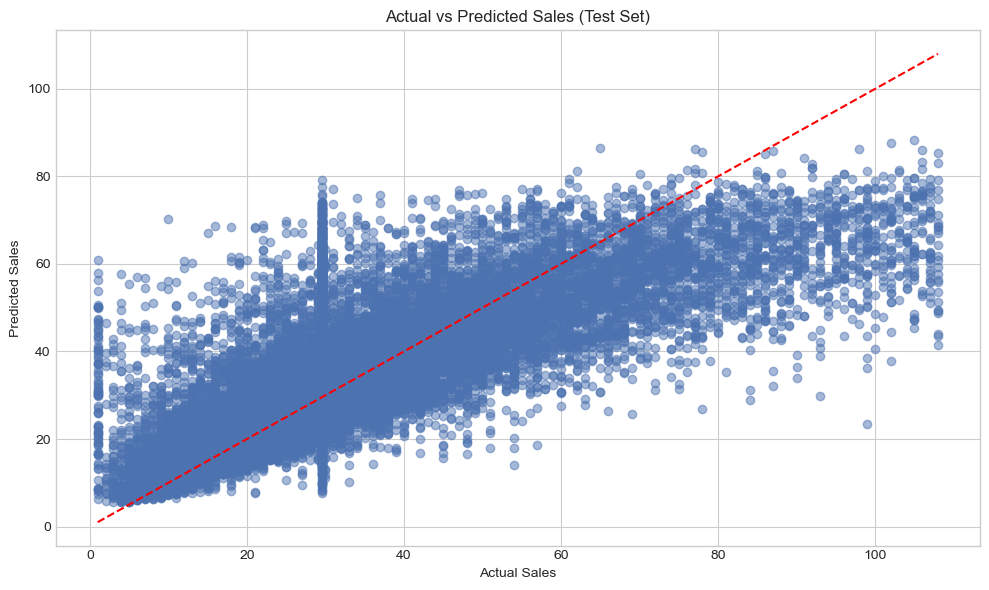

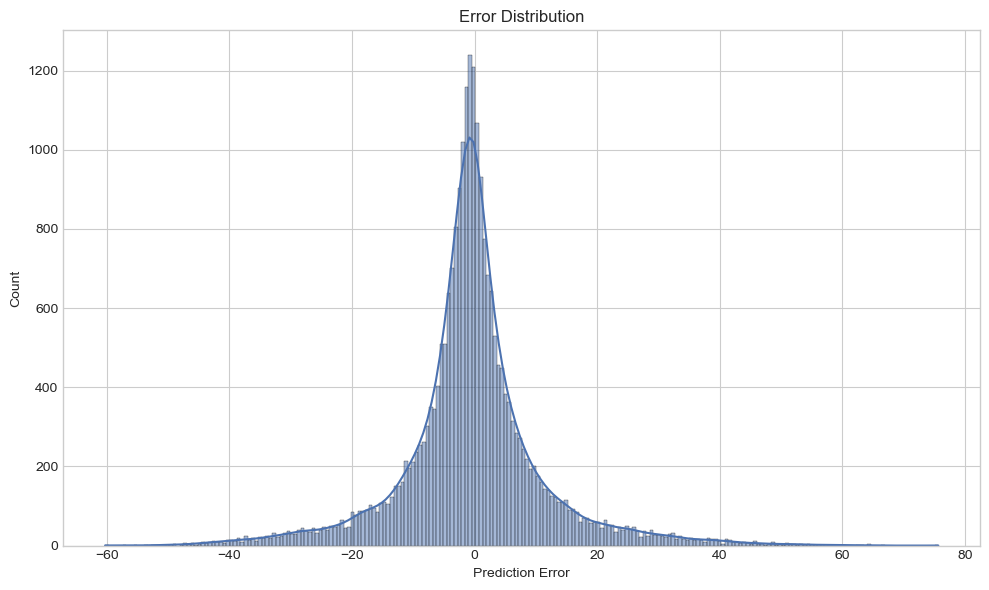

In [ ]:
# Evaluate the lightgbm model
test_mae, test_rmse, test_smape, test_preds, y_test_values, test_results = (
    evaluate_model(lightgbm_model, X_test, y_test, df_features)
)

## Save trained models

In [ ]:
def save_model(model, X_train, feature_names, output_dir="../models"):
    """
    Save the trained model and related artifacts for API use

    Args:
        model: Trained model (e.g., LightGBM model)
        feature_names: List of feature names
        output_dir: Directory to save model artifacts
    """

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save the model
    model_path = os.path.join(output_dir, "sales_forecast_model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_path}")

    # Create and save feature statistics
    feature_stats = {
        "model_version": "1.0.0",
        "last_trained": pd.Timestamp.now().strftime("%Y-%m-%d"),
        "required_columns": list(feature_names),
        "column_order": list(feature_names),
        "default_values": {},
        "temperature_bins": [-np.inf, 20, 25, 30, np.inf],
        "temperature_labels": ["Cold", "Cool", "Warm", "Hot"],
        "humidity_bins": [-np.inf, 60, 75, np.inf],
        "humidity_labels": ["Low", "Medium", "High"],
    }

    # Add default values for date features
    feature_stats["default_values"] = {
        "year": 2017,
        "month": 11,
        "day": 15,
        "day_of_week": 2,
        "is_weekend": 0,
        "quarter": 4,
        "is_holiday": 0,
    }

    # Save feature stats
    stats_path = os.path.join(output_dir, "feature_stats.json")
    with open(stats_path, "w") as f:
        json.dump(feature_stats, f, indent=4)
    print(f"Feature statistics saved to {stats_path}")

    print(f"All model artifacts saved successfully to {output_dir}/")

    return model_path, stats_path

In [ ]:
# Save model
save_model(
    model=optimized_model,
    X_train=X_train,
    feature_names=X_train.columns,
    output_dir='../models'
)

Model saved to ../models/sales_forecast_model.pkl
Feature statistics saved to ../models/feature_stats.json
All model artifacts saved successfully to ../models/


('../models/sales_forecast_model.pkl', '../models/feature_stats.json')